# Pagamentos em Atraso de Clientes de Cartão de Crédito em Taiwan em 2005
Este conjunto de dados contém informações sobre pagamentos em atraso, fatores demográficos, dados de crédito, histórico de pagamento e faturas de clientes de cartão de crédito em Taiwan, de abril de 2005 a setembro de 2005.

**Objetivo:** análise exploratória usando R

In [ ]:
# Carregando bibliotecas essenciais
library(tidyverse)    # Para manipulação de dados
library(ggplot2)      # Para visualizações
library(corrplot)     # Para matriz de correlação
library(VIM)          # Para análise de dados faltantes
library(gridExtra)    # Para múltiplos gráficos

In [2]:
# Carregando o dataset
credit_card_df <- read.csv('UCI_Credit_Card.csv')


## Limpeza e pré-processamento

A limpeza e o pré-processamento de dados, incluindo a harmonização de categorias não documentadas ou inconsistentes, são etapas que podem consumir uma porção significativa do tempo de um projeto, mas são essenciais para a validade e robustez dos modelos subsequentes (James et al., 2021).

Para fazer uma inspeção inicial nos dados, utilizo o comando `glimpse()`:

In [ ]:
# Exibie a estrutura do dataframe para entender os tipos de dados de cada coluna
glimpse(credit_card_df)

Aqui é possível perceber que as variáveis `sex`, `education` e `marriage` foram interpretadas como variáveis numéricas (`int`). Mas de acordo com a descrição das variáveis fornecidas pelo dataset são variáveis categóricas.

Então é necessário converter as colunas correspondentes a cada uma para o tipo `factor`.

In [4]:
# Seleciona as colunas categóricas e as converte para o tipo 'factor'
factor_vars <- c("SEX", "EDUCATION", "MARRIAGE", "default.payment.next.month")
credit_card_df <- credit_card_df %>%
  mutate(across(all_of(factor_vars), as.factor))

Para ter uma compreensão melhor da relação dos dados de todas as variáveis, decidi usar a função `summary()`, antes de prosseguir para os próximos passos.

In [17]:
# Exibe um sumário de todas as colunas
summary(credit_card_df[c("SEX", "EDUCATION", "MARRIAGE")])

      SEX          EDUCATION        MARRIAGE    
 Min.   :1.000   Min.   :0.000   Min.   :0.000  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:1.000  
 Median :2.000   Median :2.000   Median :2.000  
 Mean   :1.604   Mean   :1.853   Mean   :1.552  
 3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :2.000   Max.   :6.000   Max.   :3.000  

Aqui, pude perceber que as colunas **EDUCATION** e **MARRIAGE** apresentam um valor `(0)` que não está informado nas definições das variáveis do dataset disponibilizado pelo Kaggle.

Segundo a plataforma:

- **MARRIAGE:** Estado civil (1=casado, 2=solteiro, 3=outros) 
- **EDUCATION**: Escolaridade (1=pós-graduação, 2=universidade, 3=ensino médio, 4=outros, 5=desconhecido, 6=desconhecido)

Ou seja, não temos uma definição para o valor `(0)` que apresenta 14 observações em **EDUCATION** E 54 EM **MARRIAGE**. Decidi agrupar esse valor na categoria `Unknown` em **EDUCATION** e em `Others` em **MARRIAGE** para facilitar a análise.

Além disso, seguindo o exposto por (James et al., 2021), para melhorar a interpretabilidade das variáveis categóricas, decidi recodificá-las (incluindo a variável `default.payment.next.month`) para evitar a consulta contínua à descrição de cada uma.

In [6]:
# Recodificando os níveis dos fatores para torná-los descritivos
credit_card_df <- credit_card_df %>%
  mutate(
    SEX = recode_factor(SEX, `1` = "Male", `2` = "Female"),
    EDUCATION = recode_factor(EDUCATION,
                              `0` = "Unknown",
                              `1` = "Graduate School",
                              `2` = "University",
                              `3` = "High School",
                              `4` = "Others",
                              `5` = "Unknown",
                              `6` = "Unknown"),
    MARRIAGE = recode_factor(MARRIAGE, `0` = "Other", `1` = "Married", `2` = "Single", `3` = "Other"),
    # Renomeia a variável alvo para maior clareza
    default.payment.next.month = recode_factor(default.payment.next.month, `0` = "No", `1` = "Yes")
  ) %>%
  # Renomeia a variável alvo
  rename(DEFAULT = default.payment.next.month)

# Verificando as colunas modificadas para ver os novos rótulos e suas contagens
summary(credit_card_df[c("SEX", "EDUCATION", "MARRIAGE", "DEFAULT")])

     SEX                  EDUCATION        MARRIAGE     DEFAULT    
 Male  :11888   Unknown        :  345   Other  :  377   No :23364  
 Female:18112   Graduate School:10585   Married:13659   Yes: 6636  
                University     :14030   Single :15964              
                High School    : 4917                              
                Others         :  123                              

Apesar de estar utilizando a IDE Positron que já informa na visualização da tabela do dataframe se há alguma variável com dados ausentes, incluí o código abaixo com o mesmo objetivo. Apenas para seguir a EDA da forma convencional.

O tratamento de dados faltantes é um problema central em ciência de dados. A decisão de como lidar com eles (e.g., remoção de casos, imputação) pode introduzir viés e afetar significativamente o desempenho e a validade do modelo final.

In [7]:
# Conta a quantidade de valores ausentes (NA) em cada coluna
missing_values <- colSums(is.na(credit_card_df))

# Exibe apenas as colunas que contêm valores ausentes
print(missing_values[missing_values > 0])

named numeric(0)


Dado o resultado do código acima, agora sabemos que o dataset não possui lacunas nos dados. Por outro lado, a variável `education` possui valores como **"Others"** e **"Unknown"**. Diferentemente de lacunas ou de células preenchidas com **"NA"**, tais valores não são buracos no dataset. 

- **Others** (Outros): informa que, quando um cliente respondeu ao questionário para iniciar um contrato com o banco de Taiwan, seu nível de escolaridade não estava listado nas opções possíveis.
- **Unknown** (Desconhecido): por sua vez nos diz que a escolaridade do cliente é, lietralmente, desconhecida.

Um exemplo mais comum acontece quando em um formulário, na categoria **"Sexualidade"** as opções selecionáveis podem ser: "heteressexual", "homossexual", "bissexual", "outro (especificar)" e "Prefiro não responder".

Dessa forma **o dado existe**, e a importância dele está no **padrão e ausência**. Se os clientes escolhem **"Outros"** ou **"Prefiro não responder"** o fazem por algum motivo que pode se correlacionar com a inadimplência. Então, mesmo que sozinhos esses valores não possam ser possíveis de interpretação, dado todo o conjunto do dataset essas categorias em si são uma **informação valisosa**. Apagá-las sem algum critério apenas para simplificar os dados causaria viés e possivelmente colocaria toda a análise em xeque.

---

### Investigando possíveis correlações

Agora é necessário investigar se as categorias **"Others"** e **"Unknown"** apresentam algum comportamento distinto em relação à taxa de inadimplência criando uma nova variável: `education_default_rate".

In [8]:
# Calcula a taxa de inadimplência e o tamanho da amostra para cada nível de escolaridade
education_default_rate <- credit_card_df %>%
  group_by(EDUCATION) %>%
  summarise(
    DefaultRate = mean(DEFAULT == "Yes"),
    Count = n()
  ) %>%
  arrange(desc(DefaultRate))

print(education_default_rate)

# A tibble: 5 × 3
  EDUCATION       DefaultRate Count
  <fct>                 <dbl> <int>
1 High School          0.252   4917
2 University           0.237  14030
3 Graduate School      0.192  10585
4 Unknown              0.0754   345
5 Others               0.0569   123


A taxa de inadimplência com base nos níveis de educação nos mostra dados interessantes:

Clientes apenas com Ensino Médio (High School) apresentam as maiores taxas (25,2%). Um indicativo de pessoas que tiveram acesso a menos educação e/ou pessoas mais pobres que não tiveram meios para arcar com a fatura do cartão. Em contraste, clientes com Pós-graduação (Graduate School) apresentam as menores taxas (19,2%), mostrando como pessoas com acesso a educação de melhor qualidade são mais responsáveis e (possivelmente) de classes sociais mais abastadas. 

In [9]:
# Calcula a taxa de inadimplência e o tamanho da amostra para cada estado civil
marriage_default_rate <- credit_card_df %>%
  group_by(MARRIAGE) %>%
  summarise(
    DefaultRate = mean(DEFAULT == "Yes"),
    Count = n()
  ) %>%
  arrange(desc(DefaultRate))

print(marriage_default_rate)

# A tibble: 3 × 3
  MARRIAGE DefaultRate Count
  <fct>          <dbl> <int>
1 Other          0.236   377
2 Married        0.235 13659
3 Single         0.209 15964


A taxa de inadimplência a partir do tipo de estado civil não retorna informações muito relevantes. Nas três categorias a inadimplência atinge aproximadante 20% dos clientes. Mas curiosamente podemos perceber que a inadimplência em clientes casados é superior aos solteiros, isso pode ser devido ao fato que casais em geral tem gastos mais elevados que pessoas solteiras (casa, filhos, educação dos filhos, etc).

Com estas hipóteses sobre as variáveis categóricas estabelecidas, o próximo passo lógico é investigar as variáveis quantitativas.

In [10]:
# Seleciona as colunas quantitativas de interesse e exibe o resumo estatístico
summary(credit_card_df[c("AGE", "LIMIT_BAL", "PAY_0")])

      AGE          LIMIT_BAL           PAY_0        
 Min.   :21.00   Min.   :  10000   Min.   :-2.0000  
 1st Qu.:28.00   1st Qu.:  50000   1st Qu.:-1.0000  
 Median :34.00   Median : 140000   Median : 0.0000  
 Mean   :35.49   Mean   : 167484   Mean   :-0.0167  
 3rd Qu.:41.00   3rd Qu.: 240000   3rd Qu.: 0.0000  
 Max.   :79.00   Max.   :1000000   Max.   : 8.0000  

Na variável **AGE** não há nenhum ponto relevante a se analisar, apenas oservar que, aparecetemente, a ideade mínima dos clientes aceita pelo banco é de 21 anos.

Em **LIMIT_BAL**, assim como em **AGE**, não há muito o que se analisar, dado que não existe uma discrepância muito grante entre `median` e `mean`. Os dados parecem estar distribuidos de forma quase homogênea em relação à mediana, mesmo a média sendo um pouco superior dado que existem limites de crédito muito altos (1.000.000). Em outras palavras, a distribuição do limite de crédito possui uma **assimetria à direita.**

O ponto mais improtante aqui é observar a variável **PAY_0** que representa o status de pagamento para o mês de Setembro de 2005. De acordo com a descrição do dataset, seus valores devem variar de (-1) a (9), mas existe um valor mínimo (-2) que não consta nesse intervalo, então é necessário decidir como tratar ele. Mas antes, decidi fazer a mesma verificação para o status de pagamentos dos outros meses.

In [11]:
summary(credit_card_df[c("PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6")])

     PAY_0             PAY_2             PAY_3             PAY_4        
 Min.   :-2.0000   Min.   :-2.0000   Min.   :-2.0000   Min.   :-2.0000  
 1st Qu.:-1.0000   1st Qu.:-1.0000   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median : 0.0000   Median : 0.0000   Median : 0.0000   Median : 0.0000  
 Mean   :-0.0167   Mean   :-0.1338   Mean   :-0.1662   Mean   :-0.2207  
 3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   : 8.0000   Max.   : 8.0000   Max.   : 8.0000   Max.   : 8.0000  
     PAY_5             PAY_6        
 Min.   :-2.0000   Min.   :-2.0000  
 1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median : 0.0000   Median : 0.0000  
 Mean   :-0.2662   Mean   :-0.2911  
 3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   : 8.0000   Max.   : 8.0000  

Considerando o valor `0` como **uso de crédito rotativo** ou seja, de não inandimplência, podemos juntar esses valores com o valor `1` representanto todos os clientes não-inadimplentes.

In [12]:
# Seleciona as colunas de histórico de pagamento
pay_cols <- c("PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6")

# Recodifica as colunas: valores <= 0 são "Adimplente", > 0 são "Delinquent"
credit_card_df_cleaned <- credit_card_df %>%
  mutate(across(all_of(pay_cols), 
                ~factor(if_else(.x <= 0, "Adimplente", "Inadimplente"))))

# Exibe a contagem das novas categorias para PAY_0 para verificar a transformação
print(table(credit_card_df_cleaned$PAY_0))


  Adimplente Inadimplente 
       23182         6818 


 Esta técnica de agrupar múltiplos valores em categorias menores é uma forma de discretização. Ela pode simplificar o modelo, reduzir o ruído e capturar relações não-lineares de forma mais eficaz, especialmente quando há um limiar claro entre comportamentos, como inadimplente vs. não-inadimplente (Hastie et al., 2009).

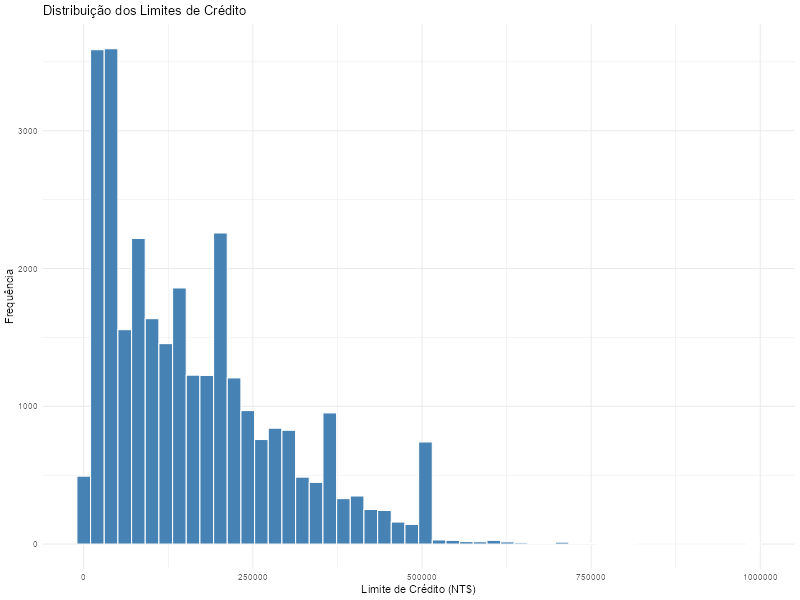

In [13]:
# Instale e carregue o pacote, se necessário
if (!require("ggplot2")) install.packages("ggplot2")
library(ggplot2)

# Cria um histograma para visualizar a distribuição de LIMIT_BAL
ggplot(credit_card_df, aes(x = LIMIT_BAL)) +
  geom_histogram(bins = 50, fill = "steelblue", color = "white") +
  labs(title = "Distribuição dos Limites de Crédito",
       x = "Limite de Crédito (NT$)",
       y = "Frequência") +
  theme_minimal()

Analisando o gráfico de distribuição de **LIMIT_BAL** podemos observar que a maioria dos clientes possuem limites baixos, destacando as barras maiores no início do eixo x, que se estende até o valor limite de 1.000.000, ode não é possível visualizar barras verticais, mas provando a existência de clientes (poucos) com limites de crédito muito altos.

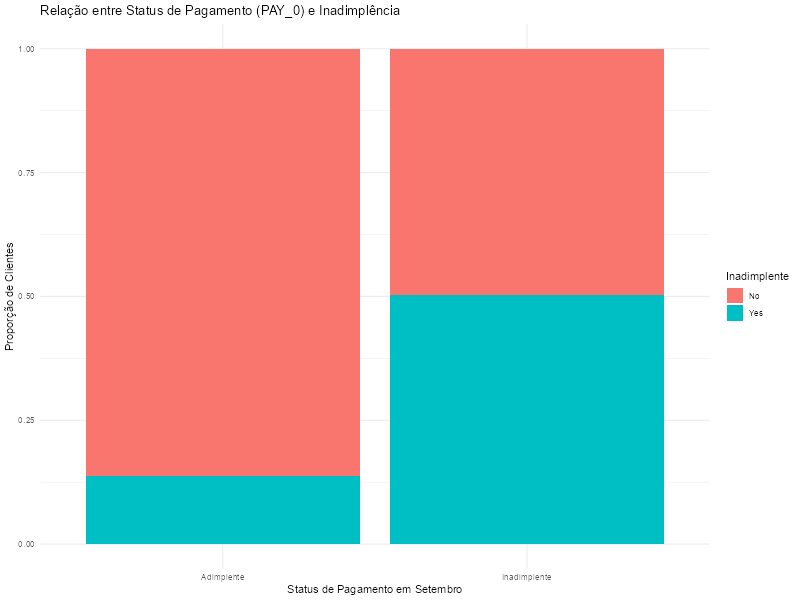

In [14]:
# Cria um gráfico de barras empilhadas por proporção
ggplot(credit_card_df_cleaned, aes(x = PAY_0, fill = DEFAULT)) +
  geom_bar(position = "fill") +
  labs(title = "Relação entre Status de Pagamento (PAY_0) e Inadimplência",
       x = "Status de Pagamento em Setembro",
       y = "Proporção de Clientes",
       fill = "Inadimplente") +
  theme_minimal()


No eixo x é possível perceber que na barra **Inadimplente** que cerca de metade dos clientes que estavam com a fatura atrasada no mês de Setembro conitnuou sem pagar a fatura no mês seguinte, msotrando a tendência de clientes inadimplentes em continuarem sem pagar suas faturas nos meses posteriores. Já na barra **Adimplente** podemos ver que uma pequena parcela dos clientes que estavam em dia, no mês seguinte se tornaram inadimplentes.

Em outras palavras, a inadimplência passada tem um altíssimo poder predititivo sob a inadimplência futura.



Rows: 30000 Columns: 25
── Column specification ──────────────────────────────────────────────────
Delimiter: ","
dbl (25): ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


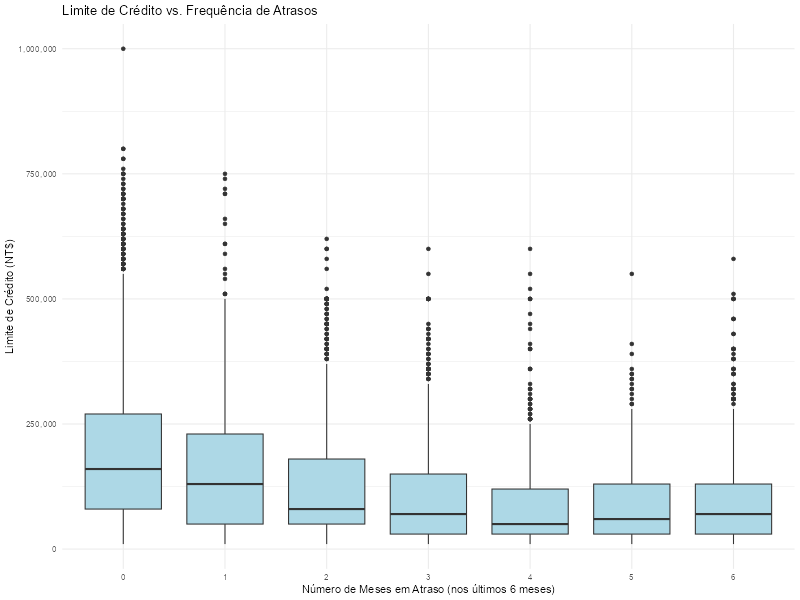

In [15]:
# Carregar o conjunto de dados original
credit_card_df <- read_csv("UCI_Credit_Card.csv")

# Definir explicitamente as colunas de status de pagamento
pay_cols <- c("PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6")

# Recodificar as colunas PAY_ para criar o dataframe 'cleaned'
credit_card_cleaned <- credit_card_df %>%
  mutate(across(all_of(pay_cols), 
                ~factor(if_else(.x <= 0, "Not Delinquent", "Delinquent"))))

# CORREÇÃO: Usar all_of(pay_cols) para selecionar apenas as colunas de status
credit_card_engineered <- credit_card_cleaned %>%
  rowwise() %>%
  mutate(DELINQUENCY_COUNT = sum(c_across(all_of(pay_cols)) == "Delinquent")) %>%
  ungroup()

# Criar o boxplot para visualizar a relação
ggplot(credit_card_engineered, aes(x = factor(DELINQUENCY_COUNT), y = LIMIT_BAL)) +
  geom_boxplot(fill = "lightblue") +
  scale_y_continuous(labels = scales::comma) +
  labs(title = "Limite de Crédito vs. Frequência de Atrasos",
       x = "Número de Meses em Atraso (nos últimos 6 meses)",
       y = "Limite de Crédito (NT$)") +
  theme_minimal()

Existe uma clara relação inversa: à medida que a frequência de atrasos (`DELINQUENCY_COUNT`) aumenta, a mediana e a dispersão geral do limite de crédito (`LIMIT_BAL`) diminuem. O grupo com 0 atrasos tem a maior mediana e a maior variabilidade de limites, enquanto os grupos com mais atrasos estão concentrados em limites de crédito mais baixos.